# 4 Elasticities
Shock elasticites are computed by solving:

$$
\varepsilon_M(t,x) = \nu(x) \cdot \left\{ \sigma_M(x) + \sigma_X(x) \cdot \frac{\partial}{\partial x} \log \mathbb{E}\left[ \left( \frac{M_t}{M_0} \right) \mid X_0 = x \right] \right\}
$$

Shock price-elasticities can be computed using:
$$
\varepsilon_M(t,x) - \varepsilon_{SM}(t,x)
$$

Where $S$ is the stochastic discount factor.

This can either be solved using finite differences or simulated. We describe both methods here.

# 2.1 Finite Differences
We solve this using the finite differences method described in Supplemental Appendix C.3:

$$
0 = - \frac{\partial f_M}{\partial t} + \Big( \mu_M + \frac{1}{2} \| \sigma_M \|^2 \Big) f_M + \big( \mu_X + \sigma_M \cdot \sigma_X \big) \cdot \frac{\partial f_M}{\partial x} + \frac{1}{2} \text{tr}\Big( \sigma_X \sigma_X' \frac{\partial^2 f_M}{\partial x \partial x'} \Big)
$$

The main function for calculating elasticities is `main_pde_shock_elasticity`, which takes in the same inputs `main_onecapital`, and uses these inputs to identify a saved solution. Hence, this function must be run after `main_onecapital` has finished running.

There are several parameters which can be changed inside the body of `main_pde_shock_elasticity`. Notably, `dt` controls the time step, where `dt`=1 is one year, while `T` controls the total number of `dt` periods for which the elasticity is computed.

Within `main_pde_shock_elasticity`, the function `compute_pde_shock_elasticity` computes shock-exposure and shock-price elasticities for a given cash flow variable $M$ and stochastic discount factor $S$. These variables are specified by inputting their drift - `mulogM` and `mulogS` - and diffusion terms - `sigmalogM` and `sigmalogS`. By default, the code computes drifts and diffusions for the following $M$ variables:

```{list-table}
:header-rows: 1

* - $M$
  - Notation in paper
  - Description
* - `logcmk`
  - $\log{\frac{C}{K}}$
  - Log consumption-capital ratio
* - `logimo`
  - $\log{\frac{I}{Y}}$
  - Log investment-output ratio
* - `logc`
  - $\log{C}$
  - Log consumption
```

And the following $S$ variables:

```{list-table}
:header-rows: 1

* - $S$
  - Notation in paper
  - Description
* - `logsdf`
  - $\hat{S}$
  - Log stochastic discount factor
* - `logn`
  - $\hat{N}$
  - Log uncertainty component of SDF
```
If the

The user can also set the initial state. `marginal_quantile` is a dictionary which computes the quantiles of the marginal stationary distribution of each state. For example, `marginal_quantile['Z'](0.5)` computes the median of the marginal distribution of `Z`. Since the states consist of $Z^1$ (`Z` in the code) and $Z^2$ (`Y` in the code), we can define the initial state as follows:

In [ ]:
initial_points = [[marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.1)],
                    [marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.5),
                    marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.9)]]

In the above example, we initialize $Z^2$ at its 10th, 50th and 90th percentiles while holding $Z^1$ at its median. 

First we import the necessary libraries:

In [1]:
import os
import sys
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RGI
import argparse
import matplotlib.pyplot as plt

os.chdir("src/1/")
from main_pde_shock_elasticity import main
from utils_FDM import finiteDiff_2D_first, finiteDiff_2D_second, finiteDiff_2D_cross
from utils_pde_shock_elasticity import computeElas
from plot_function import return_solution, plot_solution
os.chdir("../../")

Next, we set the elasticity inputs. Remember that a solution must be saved under the same parameters before the elasticities can be computed.

In [2]:
alpha = 0.0922
delta = 0.01
gamma = 1.0
Delta = 1.0
rho = 1.0
action_name = "test"

After changing these settings to your liking, we can run `main_pde_shock_elasticity`. Using default settings, this takes 20 seconds.

In [13]:
main(Delta, delta, gamma, rho, alpha, action_name)

--- 12.889362812042236 seconds for the elasticity computation ---
--- 4.820237636566162 seconds for the elasticity computation ---
--- 3.97141170501709 seconds for the elasticity computation ---


Once the above function has finished running, we can load in the results. The elasticity for each $M$ is saved as a separate `npz` file, but we can load all of them at once using the `return_solution` function.

In [24]:
res = return_solution(rho, gamma, Delta, delta, alpha, action_name)
res

{'res': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/res.npz' with keys: ymax, V, dy, a22, zz...,
 'elasticity_logc': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/elasticity_logc.npz' with keys: exposure_elasticity, price_elasticity,
 'elasticity_logimo': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/elasticity_logimo.npz' with keys: exposure_elasticity, price_elasticity,
 'uncertainty_priceelas': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/uncertainty_priceelas.npz' with keys: exposure_elasticity, price_elasticity}

For example, we can load the first-type exposure elasticities for $\hat{C}$ by accessing `['elasticity_logc']['exposure_elasticity'].item().firstType`. The first index of this object is the initial state; 0 represents the first initialization, which in this case is $Z^1$ at median and $Z^2$ at 10th percentile. The second index is the shock index; in this case, 1 represents a growth-rate shock. The third index is time. To illustrate this, we have written a simple `plot_solution` function, but the user can edit this to display their desired results.

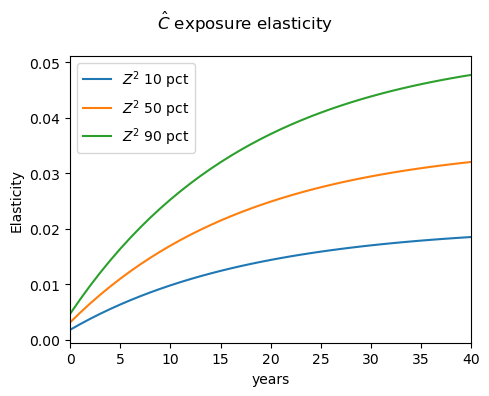

In [55]:
plot_solution(rho, gamma, Delta, delta, alpha, action_name)

# 4.2 Simulation